# **Hate Speech Detection on Reddit**

#### To develop a hate speech detection system capable of accurately identifying and classifying hate speech in real-time, ensuring a safer and more welcoming environment for Reddit users.

### **Solution Description**
##### To tackle hate speech on Reddit, a comprehensive detection system was developed using machine learning (ML) and deep learning (DL) techniques:

##### **Data Preparation:** Collected and preprocessed Reddit comments, addressed class imbalances using SMOTE.
##### **Model Development:** Implemented and optimized ML models (SVM, SGD Classifier,Random Forest etc.) and DL models (CNN, LSTM).
##### **Performance:** LSTM model achieved the best accuracy of 0.84.
##### **Prediction:** Using LSTM Model for real-time detection.

## Importing Libraries

In [1]:
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
tqdm.pandas()
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
from stop_words import get_stop_words
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer(language='english')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller

[nltk_data] Downloading package punkt to C:\Users\Aman Shekhar
[nltk_data]     Sachan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Aman Shekhar
[nltk_data]     Sachan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Dataset Description
#### The dataset used for hate speech detection is a **Benchmark dataset** consisting of 5020 entries with the following structure:

In [2]:
df = pd.read_csv('Original_Reddit.csv')

In [3]:
df.head()

,id,text,hate_speech_idx,response
0,1. e8q18lf\n2. \te8q9w5s\n3. \t\te8qbobk\n4. \...,1. A subsection of retarded Hungarians? Ohh bo...,[1],"[""I don't see a reason why it's okay to insult..."
1,1. e9c6naz\n2. \te9d03a5\n3. \t\te9d8e4d\n,"1. > ""y'all hear sumn?"" by all means I live i...",[3],['Persons with disabilities is the accepted te...
2,1. e84rl2i\n2. \te84w60l\n3. \t\te8544rn\n4. \...,1. wouldn't the defenders or whatever they are...,NaN,NaN
3,1. e7kq72n\n2. \te7m24ar\n,1. Because the Japanese aren't retarded and kn...,[1],"[""It's not right for anyone of any gender to b..."
4,1. e7hdgoh\n2. \te7iyj6a\n3. \t\te7j6iho\n4. \...,1. That might be true if we didn't have an exa...,"[2, 3]","[""You shouldn't be bringing up sensitive topic..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               5020 non-null   object
 1   text             5020 non-null   object
 2   hate_speech_idx  3847 non-null   object
 3   response         3847 non-null   object
dtypes: object(4)
memory usage: 157.0+ KB


## Restructuring the Dataset

### Restructuring the dataset to have individual rows for each comment from a post, tagging them with a 1 if they contain hate speech and 0 if not.

In [5]:
# Convert 'NaN' string to actual NaN values
df['hate_speech_idx'] = df['hate_speech_idx'].replace('NaN', pd.NA)
df['response'] = df['response'].replace('NaN', pd.NA)

# Function to split comments and mark hate speech
def process_comments(row):
    # Using regex to find the pattern "index. comment"
    pattern = re.compile(r'(\d+)\.\s(.*?)(?=\d+\.\s|$)', re.DOTALL)
    matches = pattern.findall(row['text'])
    
    # Clean and split the hate_speech_idx column
    if pd.notna(row['hate_speech_idx']):
        hate_indices = list(map(int, re.findall(r'\d+', row['hate_speech_idx'])))
    else:
        hate_indices = []
    
    processed_data = []
    
    for index, comment in matches:
        index = int(index)
        comment = comment.strip()
        is_hate_speech = 1 if index in hate_indices else 0
        processed_data.append([index, comment, is_hate_speech])
    
    return processed_data

# Apply the function and flatten the list of lists
processed_comments = df.apply(process_comments, axis=1)
processed_comments_flat = [item for sublist in processed_comments for item in sublist]

# Create a temporary DataFrame from the flattened list
df_flat = pd.DataFrame(processed_comments_flat, columns=['index', 'comment', 'hate_speech'])

# Concatenate the new data with the original DataFrame
# The original DataFrame's id column will be dropped in favor of the new columns
df = pd.concat([df.drop(columns=['text', 'hate_speech_idx', 'response','id']), df_flat], axis=1)

## Processed Dataset

In [6]:
df.head()

,index,comment,hate_speech
0,1,A subsection of retarded Hungarians? Ohh boy. ...,1
1,2,Hiii. Just got off work. 444 is mainly the typ...,0
2,3,wow i guess soyboys are the same in every country,0
3,4,Owen Benjamin's soyboy song goes for every cou...,0
4,1,"> ""y'all hear sumn?"" by all means I live in a...",0


In [7]:
df = df.drop(columns=['index'])

In [8]:
df.describe()

,hate_speech
count,22841.000000
mean,0.231864
std,0.422032
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


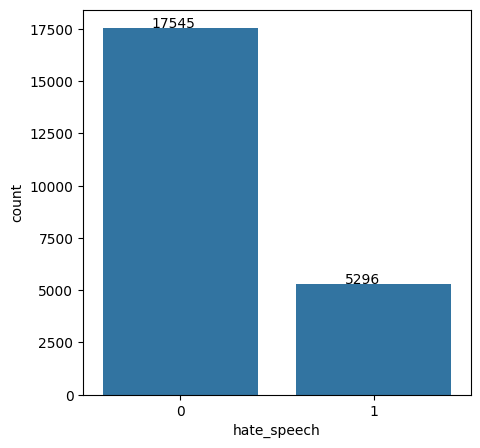

In [9]:
plt.figure(figsize=(5,5))
ax=sns.countplot(x=df['hate_speech'],data=df,order=df['hate_speech'].value_counts().index)
for p,label in zip(ax.patches,df['hate_speech'].value_counts()):
    ax.annotate(label,(p.get_x()+0.25,p.get_height()+0.5))

## Data Cleaning

#### Remove NaN values and drop comments which are deleted or removed

In [10]:
size_col0 = len(df['comment'])
size_col1 = df['comment'].count()
size_col2 = len(df['hate_speech'])
size_col3 = df['hate_speech'].count()
print("Comment Length: ", size_col0)
print("Comment Count: ", size_col1)
print("Hate Speech Length: ", size_col2)
print("Hate Speech Count: ",size_col3)

Comment Length:  22841
Comment Count:  22841
Hate Speech Length:  22841
Hate Speech Count:  22841


In [11]:
df = df.dropna().loc[(df['comment'] != '[deleted]') & (df['comment'] != '[removed]')]

In [12]:
size_col0 = len(df['comment'])
size_col1 = df['comment'].count()
size_col2 = len(df['hate_speech'])
size_col3 = df['hate_speech'].count()
print("Comment Length: ", size_col0)
print("Comment Count: ", size_col1)
print("Hate Speech Length: ", size_col2)
print("Hate Speech Count: ",size_col3)

Comment Length:  22330
Comment Count:  22330
Hate Speech Length:  22330
Hate Speech Count:  22330


## Removing HTML Tags 

#### Removing unwanted data from the text, let’s take the case of scraping data from web, where we get html tags which are unnecessary for the data,those should be removed.

In [13]:
df['comment']=df['comment'].str.lower()

def remove_html_tags(text):
    if isinstance(text, float) or text is None:  # Check for float or None and convert to empty string
        text = ''
    pattern = re.compile(r'<.*?>')
    return pattern.sub('', text)

df['comment'] = df['comment'].astype(str)
df['comment'] = df['comment'].apply(remove_html_tags)


## Removing URL

In [14]:
def remove_url(text):
    pattern=re.compile(r'https?://\s+|www.\.\S+')
    return pattern.sub(r'',text)

df['comment']=df['comment'].apply(remove_url)


## Stop words Removal 

#### Words which help in sentence formation, but does not aid any meaning to the sentence like ‘a’, ‘an’, ‘the’, ‘is’ and so on.

In [15]:
df['comment'][1]

'hiii. just got off work. 444 is mainly the typa guys you imagine writing for us stupid sites, but basically they just try to fit in with the western european and us big city hipsters.   rich kids from budapest who feel they are brave journalistic heroes.'

In [16]:
stop_words = get_stop_words('en')
def stop_words_removal(text):
    new_text=[]
    for word in text.split():
        if word in get_stop_words('en'):
            new_text.append('')
        else:
            new_text.append(word)
    return ' '.join(new_text)

df['comment']=df['comment'].apply(stop_words_removal)

In [17]:
df['comment'][1]

'hiii. just got  work. 444  mainly  typa guys  imagine writing  us stupid sites,  basically  just try  fit    western european  us big city hipsters. rich kids  budapest  feel   brave journalistic heroes.'

## Removing Punctuations 

#### When we are tokenizing the sentences, punctuations become different words. For example, "Hello! how are you?" is tokenized as [Hello , !, how ,are, you,?]. Here punctuation marks are taken as different words. It adds complexity to the model by performing more operations to the code and punctuations does not attribute any meaning to the sentence.

In [18]:
df['comment'][1]

'hiii. just got  work. 444  mainly  typa guys  imagine writing  us stupid sites,  basically  just try  fit    western european  us big city hipsters. rich kids  budapest  feel   brave journalistic heroes.'

In [19]:
print(string.punctuation)
exclude=string.punctuation

def remove_punctuation(text):
    for char in exclude:
        text=text.replace(char,'')
    return text

df['comment']=df['comment'].apply(remove_punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [20]:
df['comment'][1]

'hiii just got  work 444  mainly  typa guys  imagine writing  us stupid sites  basically  just try  fit    western european  us big city hipsters rich kids  budapest  feel   brave journalistic heroes'

## Chat Word Treatment 

#### Words like ROFL,LMAO,FYI,GD,ASAP, are found in chat messages of many social media platforms like WhatsApp, Instagram, Twitter. While summarizing the text, to understand the meaning of the word, these short words should be replaced with long forms. 

In [21]:
chat_words={'AFAIK': 'As Far As I Know',
'AFK':'Away From Keyboard',
'ASAP':'As Soon As Possible',
'ATK':'At The Keyboard',
'ATM':'At The Moment',
'A3':'Anytime, Anywhere, Anyplace',
'BAK':'Back At Keyboard',
'BBL': 'Be Back Later',
'BBS': 'Be Back Soon',
'BFN': 'Bye For Now',
'B4N': 'Bye For Now',
'BRB': 'Be Right Back',
'BRT': 'Be Right There',
'BTW': 'By The Way',
'B4': 'Before',
'B4N': 'Bye For Now',
'CU':'See You',
'CUL8R':'See You Later',
'CYA': 'See You',
'FAQ': 'Frequently Asked Questions',
'FC': 'Fingers Crossed',
'FWIW': 'For What Its Worth',
'FYI': 'For Your Information',
'GAL': 'Get A Life',
'GG': 'Good Game',
'GN' : 'Good Night',
'GMTA': 'Great Minds Think Alike',
'GR8': 'Great!',
'G9': 'Genius',
'IC': 'I See',
'ICQ': 'I Seek you (also a chat program)',
'ILU': 'I Love You',
'IMHO': 'In My Honest/Humble Opinion',
'IMO':'In My Opinion',
'IOW':'In Other Words',
'IRL': 'In Real Life',
'KISS':'Keep It Simple, Stupid',
'LDR':'Long Distance Relationship',
'LMAO':'Laugh My A.. Off',
'LOL':'Laughing Out Loud',
'LTNS': 'Long Time No See',
'L8R': 'Later',
'MTE': 'My Thoughts Exactly',
'M8': 'Mate',
'NRN': 'No Reply Necessary',
'OIC':'Oh I See',
'PITA':'Pain In The A..',
'PRT': 'Party',
'PRW':'Parents Are Watching',
'QPSA':	'Que Pasa?',
'ROFL':'Rolling On The Floor Laughing',
'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
'ROTFLMAO':'Rolling On The Floor Laughing My A.. Off',
'SK8':'Skate',
'STATS':'Your sex and age',
'ASL':'Age, Sex, Location',
'THX':'Thank You',
'TTFN':'Ta-Ta For Now!',
'TTYL':'Talk To You Later',
'U':'You',
'U2':'You Too',
'U4E':'Yours For Ever',
'WB':'Welcome Back',
'WTF':'What The F...',
'WTG':'Way To Go!',
'WUF':'Where Are You From?',
'W8':'Wait...',
'7K':'Sick'}

In [22]:
df['comment'][16]

' apparently  don’t study    either    had you’d know   muchanticipated modern reformation  islam will never actually happen  i’m wasting  time   think marxism   positive influence   christian west   retarded last  checked atheists still need food lol'

In [23]:
def chat_word(text):
    new_text=[]
    for word in text.split():
        if word.upper() in chat_words:
            new_text.append(chat_words[word.upper()])
        else:
            new_text.append(word)
            
    return " ".join(new_text)

df['comment']=df['comment'].apply(chat_word)

In [24]:
df['comment'][16]

'apparently don’t study either had you’d know muchanticipated modern reformation islam will never actually happen i’m wasting time think marxism positive influence christian west retarded last checked atheists still need food Laughing Out Loud'

## Handling Emoji’s 

#### While analyzing chatting messages, for text classification or sentiment analysis, emoji’s particularly have a meaning, we can replace emoji expression with their corresponding meaning. If our problem statement does not have anything to do with sentiments or feelings,we can remove them. 

In [25]:
def emoji_removal(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['comment']=df['comment'].apply(emoji_removal)

## Remove extra spaces

In [26]:
# Function to clean up extra spaces in a string
def clean_spaces(text):
    if isinstance(text, str):
        # Remove multiple consecutive spaces
        text = re.sub(r'\s{2,}', ' ', text)
        # Trim leading and trailing spaces
        text = text.strip()
    return text

# Apply the cleaning function to each cell in the DataFrame
df = df.applymap(clean_spaces)

C:\Users\Aman Shekhar Sachan\AppData\Local\Temp\ipykernel_15516\1291788884.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(clean_spaces)


In [27]:
df.head()

,comment,hate_speech
0,subsection retarded hungarians ohh boy brace l...,1
1,hiii just got work 444 mainly typa guys imagin...,0
2,wow guess soyboys every country,0
3,owen benjamins soyboy song goes every country ...,0
4,yall hear sumn means live small town rn for wo...,0


## Remove Numbers


In [28]:
import pandas as pd
import re

# Define the file paths
input_file_path = 'Cleaned_spaces_Reddit.csv'
output_file_path = 'processed_Reddit.csv'

# Dictionary of number meanings
number_meanings = {
    '111': 'Alignment and manifestation',
    '1111': 'New beginnings and unity',
    '222': 'Balance and harmony',
    '333': 'Protection and encouragement',
    '444': 'Foundation and grounding',
    '555': 'Change and transformation',
    '666': 'Reflection and personal development',
    '777': 'Spiritual growth and good fortune',
    '888': 'Abundance and success',
    '999': 'Completion and closure',
    '1010': 'Personal development and growth',
    '1212': 'Spiritual awakening and higher consciousness',
    '1234': 'Progress and moving forward',
    '2222': 'Peace and balance in life',
    '3333': 'Divine protection and guidance',
    '4444': 'Strong foundation and support',
    '5555': 'Major life changes',
    '6666': 'Reflecting on past choices',
    '7777': 'Luck and spiritual awareness',
    '8888': 'Financial abundance and prosperity',
    '9999': 'Endings leading to new beginnings',
    '1001': 'Self-improvement and new perspectives',
    '1101': 'Opening new doors and opportunities',
    '1211': 'Embracing new phases in life',
    '1233': 'Balanced progress and harmony',
    '1441': 'Foundation and new opportunities',
    '1515': 'Personal growth and freedom',
    '1616': 'Stability and inner strength',
    '1717': 'Awakening and self-awareness',
    '1818': 'Financial success and independence',
    '1919': 'Completion of cycles and new beginnings',
    '2020': 'Vision and clarity',
    '2121': 'Positive change and new opportunities',
    '2323': 'Creativity and self-expression',
    '2424': 'Building strong foundations',
    '2525': 'Adaptability and positive change',
    '2626': 'Nurturing and care for loved ones',
    '2727': 'Spiritual awareness and inner wisdom',
    '2828': 'Abundance and prosperity',
    '2929': 'Transformation and new phases',
    '3030': 'Creativity and communication',
    '3131': 'Optimism and positive energy',
    '3232': 'Faith and trust in the universe',
    '3434': 'Stability and determination',
    '3535': 'Personal freedom and individuality',
    '3636': 'Nurturing and compassion',
    '3737': 'Spiritual growth and awareness',
    '3838': 'Ab'}


In [29]:

# Function to replace or remove numbers in a string
def replace_numbers(text, number_meanings):
    if isinstance(text, str):
        # Find all numbers in the text
        numbers = re.findall(r'\b\d+\b', text)
        for number in numbers:
            if number in number_meanings:
                # Replace number with its meaning
                text = re.sub(r'\b' + re.escape(number) + r'\b', number_meanings[number], text)
            else:
                # Remove number if no meaning exists
                text = re.sub(r'\b' + re.escape(number) + r'\b', '', text)
        # Remove any extra spaces after replacement/removal
        text = re.sub(r'\s{2,}', ' ', text).strip()
    return text

# Apply the number replacement function to each cell in the DataFrame
df = df.applymap(lambda x: replace_numbers(x, number_meanings))

C:\Users\Aman Shekhar Sachan\AppData\Local\Temp\ipykernel_15516\947521680.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: replace_numbers(x, number_meanings))


In [30]:
df.head()

,comment,hate_speech
0,subsection retarded hungarians ohh boy brace l...,1
1,hiii just got work Foundation and grounding ma...,0
2,wow guess soyboys every country,0
3,owen benjamins soyboy song goes every country ...,0
4,yall hear sumn means live small town rn for wo...,0


## Apply Autocorrect

In [31]:
from autocorrect import Speller
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Initialize the spell checker
spell = Speller()

# Define the autocorrect function
def autocorrect_text(text):
    if isinstance(text, str):
        return spell(text)
    return text

# Function to apply autocorrect in parallel
def parallel_apply(data, func, workers=4):
    with ThreadPoolExecutor(max_workers=workers) as executor:
        results = list(tqdm(executor.map(func, data), total=len(data)))
    return results

# Choose the columns to apply autocorrect
target_columns = ['comment']

# Apply autocorrect to each target column in parallel
for column in target_columns:
    df[column] = parallel_apply(df[column], autocorrect_text)


100%|██████████████████████████████████████████████████████████████████████████| 22330/22330 [5:33:10<00:00,  1.12it/s]


#### Preprocessed Dataset

In [32]:
df.head()

,comment,hate_speech
0,subsection retarded hungarian oh boy brace liv...,1
1,iii just got work Foundation and grounding mai...,0
2,wow guess cowboys every country,0
3,owen benjamin cowboy song goes every country a...,0
4,all hear sun means live small town rn for work...,0


In [33]:
df.to_csv('Reddit_AK_Final.csv', index=False)
print("File saved")

File saved


## Tokenization and Encoding(Fasttext)

In [34]:
df= pd.read_csv('Reddit_AK_Final.csv')

In [37]:
print(df.isnull().sum())

comment        130
hate_speech      0
dtype: int64


In [38]:
df.dropna(inplace=True)

In [39]:
print(df.isnull().sum())

comment        0
hate_speech    0
dtype: int64


In [40]:
df['words'] = df['comment'].apply(lambda x: word_tokenize(x))
df.head()

,comment,hate_speech,words
0,subsection retarded hungarian oh boy brace liv...,1,"[subsection, retarded, hungarian, oh, boy, bra..."
1,iii just got work Foundation and grounding mai...,0,"[iii, just, got, work, Foundation, and, ground..."
2,wow guess cowboys every country,0,"[wow, guess, cowboys, every, country]"
3,owen benjamin cowboy song goes every country a...,0,"[owen, benjamin, cowboy, song, goes, every, co..."
4,all hear sun means live small town rn for work...,0,"[all, hear, sun, means, live, small, town, rn,..."


In [41]:
lemmatizer = WordNetLemmatizer()
df['lemmatized_comment'] = df['words'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos='v') for word in x]))

df['tokens'] = df['lemmatized_comment'].apply(lambda x: x.split())

In [1]:
import fasttext
# Load the FastText model
ft_model = fasttext.load_model('cc.en.300.bin')

In [44]:
# Get word vectors for each token
df['word_vectors'] = df['tokens'].apply(lambda tokens: [ft_model.get_word_vector(token) for token in tokens])
# Function to average word vectors
def average_word_vectors(word_vectors):
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(ft_model.get_dimension())

# Aggregate word vectors for each document
df['document_vector'] = df['word_vectors'].apply(average_word_vectors)

df['document_vector_flat'] = df['document_vector'].apply(lambda vec: ','.join(map(str, vec)))
print(df[['comment', 'document_vector_flat']].head())


# Save the result to a CSV file
output_file = 'Processed_Reddit_Encoded_AK.csv'
df.to_csv(output_file, index=False,  columns=['comment', 'hate_speech', 'lemmatized_comment', 'document_vector_flat'])

print("File saved as", output_file)

                                             comment  \
0  subsection retarded hungarian oh boy brace liv...   
1  iii just got work Foundation and grounding mai...   
2                    wow guess cowboys every country   
3  owen benjamin cowboy song goes every country a...   
4  all hear sun means live small town rn for work...   

                                document_vector_flat  
0  0.019159256,-0.04540207,-0.013310673,0.0693318...  
1  -0.009258354,-0.03500584,0.024274409,0.0689532...  
2  0.031344395,-0.006678687,0.02832899,0.08750783...  
3  0.027822988,-0.0011368291,-0.0047952645,0.0754...  
4  0.020198364,0.010235707,0.00050375995,0.065230...  
File saved as Processed_Reddit_Encoded_AK.csv


### Train and Test Splitting(by 80% and 20%)

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split


In [5]:
df = pd.read_csv('Processed_Reddit_Encoded_AK.csv')
df.head()

,comment,hate_speech,lemmatized_comment,document_vector_flat
0,subsection retarded hungarian oh boy brace liv...,1,subsection retard hungarian oh boy brace live ...,"0.019159256,-0.04540207,-0.013310673,0.0693318..."
1,iii just got work Foundation and grounding mai...,0,iii just get work Foundation and ground mainly...,"-0.009258354,-0.03500584,0.024274409,0.0689532..."
2,wow guess cowboys every country,0,wow guess cowboys every country,"0.031344395,-0.006678687,0.02832899,0.08750783..."
3,owen benjamin cowboy song goes every country a...,0,owen benjamin cowboy song go every country amaze,"0.027822988,-0.0011368291,-0.0047952645,0.0754..."
4,all hear sun means live small town rn for work...,0,all hear sun mean live small town rn for work ...,"0.020198364,0.010235707,0.00050375995,0.065230..."


In [6]:
# Convert the document vectors from their string representation back into numerical form
df['document_vector'] = df['document_vector_flat'].apply(lambda x: np.fromstring(x, sep=','))

# Ensure the conversion was successful
print(df['document_vector'].head())

0    [0.019159256, -0.04540207, -0.013310673, 0.069...
1    [-0.009258354, -0.03500584, 0.024274409, 0.068...
2    [0.031344395, -0.006678687, 0.02832899, 0.0875...
3    [0.027822988, -0.0011368291, -0.0047952645, 0....
4    [0.020198364, 0.010235707, 0.00050375995, 0.06...
Name: document_vector, dtype: object


In [7]:
from sklearn.model_selection import train_test_split
# Extract features (document vectors) and labels (hate speech)
X = np.array(df['document_vector'].tolist())
y = df['hate_speech']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the datasets
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (17760, 300)
Testing data shape: (4440, 300)


## Imbalanced data handling (SMOTE)

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

df = pd.read_csv('Reddit_Encoded.csv')
df.head()

,comment,hate_speech,lemmatized_comment,document_vector_flat
0,subsection retarded hungarians ohh boy brace l...,1,subsection retard hungarians ohh boy brace liv...,"0.014043219,-0.01809359,0.017145459,0.08062436..."
1,hiii just got work Foundation and grounding ma...,0,hiii just get work Foundation and ground mainl...,"-0.0030388932,-0.035133556,0.020659983,0.07383..."
2,wow guess soyboys every country,0,wow guess soyboys every country,"0.017362628,0.005587179,0.0297773,0.109146975,..."
3,owen benjamins soyboy song goes every country ...,0,owen benjamins soyboy song go every country amaze,"0.018085241,0.0011954829,2.8959475e-05,0.07601..."
4,yall hear sumn means live small town rn for w...,0,yall hear sumn mean live small town rn for wor...,"0.023993038,-0.00060867134,0.005239945,0.05989..."


In [2]:
# Extract features and labels
X = df[['lemmatized_comment', 'document_vector_flat']]
y = df['hate_speech']

# Convert document vectors to numerical form
X['document_vector_flat'] = X['document_vector_flat'].apply(lambda x: np.array([float(i) for i in x.split(',')]))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle document vectors separately
X_train_vectors = np.stack(X_train['document_vector_flat'].values)
X_test_vectors = np.stack(X_test['document_vector_flat'].values)

# Optional: Combine features if needed
combined_train_features = [X_train['lemmatized_comment'].values, X_train_vectors]
combined_test_features = [X_test['lemmatized_comment'].values, X_test_vectors]

# Print shapes to confirm
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("X_train_vectors shape:", X_train_vectors.shape)
print("X_test_vectors shape:", X_test_vectors.shape)


C:\Users\Aman Shekhar Sachan\AppData\Local\Temp\ipykernel_1312\1435646104.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['document_vector_flat'] = X['document_vector_flat'].apply(lambda x: np.array([float(i) for i in x.split(',')]))


X_train shape: (17768, 2)
X_test shape: (4443, 2)
y_train shape: (17768,)
y_test shape: (4443,)
X_train_vectors shape: (17768, 300)
X_test_vectors shape: (4443, 300)


Class distribution after applying SMOTE:
Counter({0: 13539, 1: 13539})


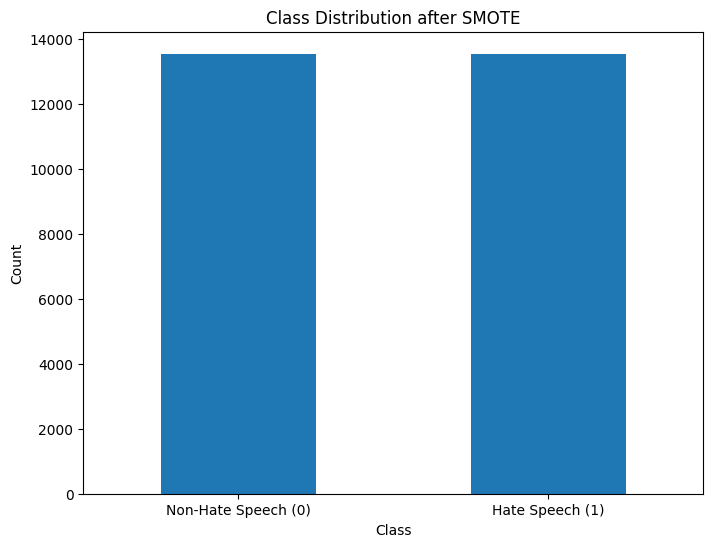

X_train_resampled_vectors shape: (27078, 300)
y_train_resampled shape: (27078,)


In [9]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled_vectors, y_train_resampled = smote.fit_resample(X_train_vectors, y_train)

# Display the new class distribution after applying SMOTE
print("Class distribution after applying SMOTE:")
print(Counter(y_train_resampled))

# Optional: Plot the new distribution
plt.figure(figsize=(8, 6))
pd.Series(y_train_resampled).value_counts().plot(kind='bar')
plt.title('Class Distribution after SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Hate Speech (0)', 'Hate Speech (1)'], rotation=0)
plt.show()

# Print shapes to confirm
print("X_train_resampled_vectors shape:", X_train_resampled_vectors.shape)
print("y_train_resampled shape:", y_train_resampled.shape)


### now save balanced train file and the test file in csv format

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM


In [4]:
# Load the balanced training data and test data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Separate features and labels
X_train = train_data.drop(columns=['hate_speech', 'lemmatized_comment'])
y_train = train_data['hate_speech']

X_test = test_data.drop(columns=['hate_speech', 'lemmatized_comment'])
y_test = test_data['hate_speech']

# Convert DataFrames to numpy arrays-keras require inpute data in numpy array format
X_train = np.array(X_train)
X_test = np.array(X_test)

# Ensure the labels are in the correct format
y_train = np.array(y_train)
y_test = np.array(y_test)

# Reshape the input data to be 3D [samples, time steps, features]
# This is necessary for Conv1D and LSTM layers which expect 3D input
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


C:\Users\Aman Shekhar Sachan\AppData\Local\Temp\ipykernel_6312\2809165132.py:2: DtypeWarning: Columns (300) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train.csv')


## ***Deep Learning Models (LSTM)***

In [36]:
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, Embedding, SpatialDropout1D, Bidirectional

# Define the LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=input_shape))
    model.add(SpatialDropout1D(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [37]:
# LSTM Model
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_model.summary()
lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

C:\Users\Aman Shekhar Sachan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 1, 200)              │         320,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ (None, 1, 200)              │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 341,001 (1.30 MB)

 Trainable params: 341,001 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.6808 - loss: 0.5958 - val_accuracy: 0.6433 - val_loss: 0.6535
Epoch 2/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7669 - loss: 0.4749 - val_accuracy: 0.7179 - val_loss: 0.5818
Epoch 3/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7764 - loss: 0.4587 - val_accuracy: 0.6802 - val_loss: 0.6545
Epoch 4/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7885 - loss: 0.4434 - val_accuracy: 0.6784 - val_loss: 0.6486
Epoch 5/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7988 - loss: 0.4248 - val_accuracy: 0.5685 - val_loss: 0.7592
Epoch 6/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8068 - loss: 0.4185 - val_accuracy: 0.7400 - val_loss: 0.5549
Epoch 7/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8127 - loss: 0.4136 - val_accuracy: 0.7548 - val_loss: 0.5313
Epoch 8/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8191 - loss: 0.4014 - val_acc

In [41]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
# Evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    return y_pred

print("\n--- LSTM Model Evaluation ---")
lstm_predictions= evaluate_model(lstm_model, X_test, y_test)


--- LSTM Model Evaluation ---
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.8438
Precision: 0.6537
Recall: 0.7304
F1 Score: 0.6899
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      3386
           1       0.65      0.73      0.69      1057

    accuracy                           0.84      4443
   macro avg       0.78      0.80      0.79      4443
weighted avg       0.85      0.84      0.85      4443



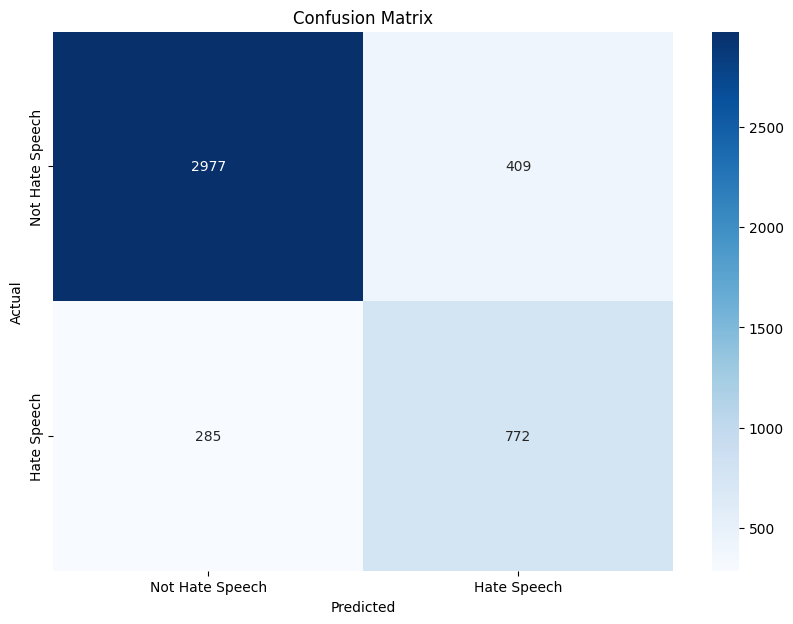

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hate Speech', 'Hate Speech'], yticklabels=['Not Hate Speech', 'Hate Speech'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix for CNN model
plot_confusion_matrix(y_test, lstm_predictions)

#### Based on the evaluation results of the LSTM model, we have surpassed our previous benchmark scores. Our accuracy and F1-score for hate speech prediction have improved, reaching 84% accuracy and an F1-score of 69%, compared to our previous benchmark of 82% accuracy and 62% F1-score in our initial machine learning models(SVM).


## Prediction of Model Performance

In [2]:
import fasttext
# Load the FastText model
ft_model = fasttext.load_model('cc.en.300.bin')

In [43]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import fasttext
# load fasttext model- cc.en.300.bin
# Function to preprocess texts using FastText for vectorization
def preprocess_texts(texts, ft_model):
    preprocessed_texts = []
    for text in texts:
        # Split text into words
        words = text.split()
        # Get FastText embeddings for each word
        word_vectors = [ft_model.get_word_vector(word) for word in words]
        # Average the word vectors to get text vector
        text_vector = np.mean(word_vectors, axis=0)
        preprocessed_texts.append(text_vector)
    return np.array(preprocessed_texts)

# Function to predict hate speech for given text samples
def predict_hate_speech(texts, lstm_model, ft_model):
    # Preprocess texts using FastText for vectorization
    X_samples = preprocess_texts(texts, ft_model)
    
    # Reshape the input data to be 3D [samples, time steps, features]
    X_samples = X_samples.reshape((X_samples.shape[0], 1, X_samples.shape[1]))
    
    # Predict using the model
    predictions = lstm_model.predict(X_samples)
    predictions = (predictions > 0.5).astype("int32")
    
    # Print predictions
    for text, prediction in zip(texts, predictions):
        label = 'Hate Speech' if prediction == 1 else 'Not Hate Speech'
        print(f"Text: {text}\nPrediction: {label}\n")



In [44]:
# Example of a few sample texts for prediction
sample_texts = [
    "This is a terrible thing to say.",
    "You are a good person!",
    "I hate everyone.",
    "Jun, You are a bitch",
    "Kim, You are bitch",
    "Karim, fuck you",
    "I hope you die, bitch",
    "You ever fuck a bitch and she start to cry?",
    "The new restaurant in town has amazing food and great service.",
]


In [45]:
# Call the prediction function
predict_hate_speech(sample_texts, lstm_model, ft_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Text: This is a terrible thing to say.
Prediction: Not Hate Speech

Text: You are a good person!
Prediction: Not Hate Speech

Text: I hate everyone.
Prediction: Not Hate Speech

Text: Jun, You are a bitch
Prediction: Hate Speech

Text: Kim, You are bitch
Prediction: Hate Speech

Text: Karim, fuck you
Prediction: Hate Speech

Text: I hope you die, bitch
Prediction: Hate Speech

Text: You ever fuck a bitch and she start to cry?
Prediction: Hate Speech

Text: The new restaurant in town has amazing food and great service.
Prediction: Not Hate Speech

